# Define unit cell geometry and generate Voronoi regions with random seed

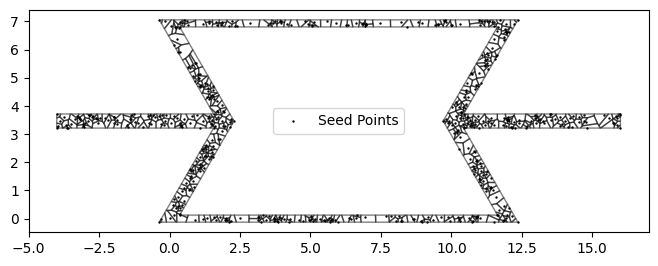

In [ ]:
import numpy as np
from shapely.geometry import Point, Polygon, LineString, MultiLineString
from shapely.ops import unary_union, linemerge
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from math import pi,sin,cos,tan
from scipy.spatial import cKDTree

# This function handles Voronoi regions with infinite area
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2  # To extend far beyond our dimensional limit

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            # Project the infinite edge outward
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = midpoint + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())


        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Here, we define our cell geometry's parameters
l = 4.
h = 12.
theta = 60 * pi / 180
t = 0.5
line_thickness = 0.1

# Define unit cell polygons
outer_coords = [(-t/(2*sin(theta)) - (t/(4*(tan(theta)))), -t/4), (h + (t/(2*sin(theta))) + (t/(4*tan(theta))), -t/4),
                (h - (l*cos(theta)) + (t/(2*sin(theta))) + (t/(2*(tan(theta)))), l*sin(theta) - (t/2)), (h - l*cos(theta) + (h/2), l*sin(theta) - (t/2)),
                (h - l*cos(theta) + (h/2), l*sin(theta) + (t/2)), (h - (l*cos(theta)) + (t/(2*sin(theta))) + (t/(2*(tan(theta)))), l*sin(theta) + (t/2)),
                (h + (t/(2*sin(theta))) + (t/(4*tan(theta))), 2*l*sin(theta) + t/4), (-t/(2*sin(theta)) - (t/(4*(tan(theta)))), 2*l*sin(theta) + t/4),
                (l*cos(theta) - (t/(2*sin(theta))) - (t/(2*tan(theta))), l*sin(theta) + (t/2)), (l*cos(theta) - (h/2), l*sin(theta) + (t/2)),
                (l*cos(theta) - (h/2), l*sin(theta) - (t/2)), (l*cos(theta) - (t/(2*sin(theta))) - (t/(2*tan(theta))), l*sin(theta) - (t/2))
]
outer_poly = Polygon(outer_coords)


inner_coords = [((t/(2*sin(theta))) + (t/(4*tan(theta))), (t/4)), (h - (t/(2*sin(theta))) - (t/(4*tan(theta))), (t/4)),
                (h - l*cos(theta) - (t/(2*sin(theta))), l*sin(theta)), (h - (t/(2*sin(theta))) - (t/(4*tan(theta))), 2*l*sin(theta) - (t/4)),
                ((t/(2*sin(theta))) + (t/(4*tan(theta))), 2*l*sin(theta) - (t/4)), (l*cos(theta) + (t/(2*sin(theta))), l*sin(theta))
]
inner_poly = Polygon(inner_coords)

ring_poly = outer_poly.difference(inner_poly)

# Generate points (including corners)
corner_points = np.array(outer_coords + inner_coords)
points = corner_points.tolist()

# Add random points from our design space(will serve as seeds for Voronoi generation)
n_points = 500
minx, miny, maxx, maxy = ring_poly.bounds
while len(points) < n_points:
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    if ring_poly.contains(Point(x, y)):
        points.append([x, y])
points = np.array(points)

# Generate Voronoi with finite area
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=2 * max(h, 2 * l * sin(theta)))

# Clip cells to the ring_poly
cells = []
for region in regions:
    poly = Polygon(vertices[region]).intersection(ring_poly)
    if not poly.is_empty:
        cells.append(poly)

# Plot the heirarchical unit cell
fig, ax = plt.subplots(figsize=(8, 8))
for cell in cells:
    if cell.geom_type == 'Polygon':
        x, y = cell.exterior.xy
        ax.fill(x, y, facecolor = 'none', alpha=0.5, edgecolor='black')
    elif cell.geom_type == 'MultiPolygon':
        for geom in cell.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, facecolor = 'none',  alpha=0.5, edgecolor='black')

# Visualize the random seed points
ax.scatter(points[:,0], points[:,1], color='black', s=0.5, label='Seed Points')

ax.set_aspect('equal')
plt.legend()
plt.show()

# Use poisson disk sampling for uniformity

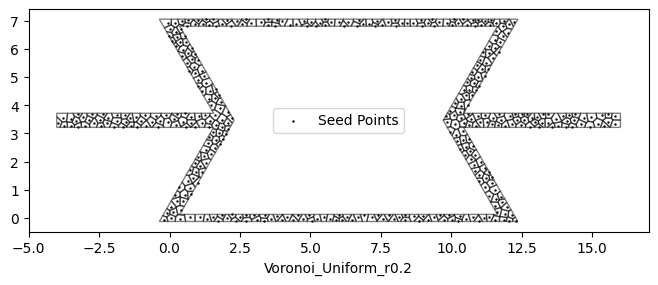

In [21]:
# we use Poisson disk sampling using Bridson’s Algorithm  to correct the corner cell issue by creating a uniform point distribution even before creating voronoi structures.
def poisson_disk_sampling(domain_polygon, r, k=30):

    minx, miny, maxx, maxy = domain_polygon.bounds
    cell_size = r / np.sqrt(2)

    grid = {}
    active_list = []

    # randomly sample a first point inside the polygon
    while True:
        p0 = np.array([np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)])
        if domain_polygon.contains(Point(p0)):
            active_list.append(p0)
            grid[tuple(p0)] = p0
            break

    # generate fresh points
    points = [p0]

    while active_list:
        idx = np.random.randint(len(active_list))
        point = active_list[idx]

        # generate k candidate points
        found_new_point = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            radius = np.random.uniform(r, 2 * r)
            new_point = point + radius * np.array([np.cos(theta), np.sin(theta)])

            # check if points are within dimensional bounds
            if not domain_polygon.contains(Point(new_point)):
                continue

            # check distance
            if len(points) > 0:
                tree = cKDTree(points)
                distances, _ = tree.query(new_point, k=1)
                if distances < r:
                    continue  # Too close

            # add vaid points to lists
            active_list.append(new_point)
            grid[tuple(new_point)] = new_point
            points.append(new_point)
            found_new_point = True

        if not found_new_point:
            active_list.pop(idx)

    return np.array(points)

# run Poisson Disk Sampling
r = 0.2  # his is the user-defined distance between two neighbouring seed points. Changing this affects the density of the generated Voronoi regions
points = poisson_disk_sampling(ring_poly, r)

vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=2 * max(h, 2 * l * sin(theta)))

cells = []
for region in regions:
    poly = Polygon(vertices[region]).intersection(ring_poly)
    if not poly.is_empty:
        cells.append(poly)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
for cell in cells:
    if cell.geom_type == 'Polygon':
        x, y = cell.exterior.xy
        ax.fill(x, y, facecolor = 'none', alpha=0.5, edgecolor='black')
    elif cell.geom_type == 'MultiPolygon':
        for geom in cell.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, facecolor = 'none', alpha=0.5, edgecolor='black')

figname = "Voronoi_Uniform_r" + str(r) + ".png"

# Plot seed points
ax.scatter(points[:,0], points[:,1], color='black', s=0.5, label='Seed Points')

ax.set_aspect('equal')
plt.legend()
plt.xlabel("Voronoi_Uniform_r" + str(r))
plt.savefig(figname, dpi=1000)
plt.show()

# Find relative density by dividing the total area occupied by the lines with the toal area of the unit cell

In [ ]:
# Identify boundary points (first 12 points: 6 outer + 6 inner corners)
n_corner_points = len(outer_coords) + len(inner_coords)  # = 12
boundary_point_indices = set(range(n_corner_points))

unique_voronoi_edges = []

# Process finite ridges
for ridge_idx, ridge in enumerate(vor.ridge_vertices):
    if -1 in ridge:
        continue

    p1, p2 = vor.ridge_points[ridge_idx]

    # Skip edges connected to boundary/corner points
    if p1 in boundary_point_indices or p2 in boundary_point_indices:
        continue

    line = LineString([vor.vertices[ridge[0]], vor.vertices[ridge[1]]])
    clipped_line = line.intersection(ring_poly)
    if not clipped_line.is_empty:
        unique_voronoi_edges.append(clipped_line)

# Process infinite ridges
for ridge_idx, ridge in enumerate(vor.ridge_vertices):
    if -1 not in ridge:
        continue  # Skip finite ridges

    # Get the two points forming this ridge
    p1, p2 = vor.ridge_points[ridge_idx]

    # Skip edges connected to boundary/corner points
    if p1 in boundary_point_indices or p2 in boundary_point_indices:
        continue

    # Reconstruct infinite edge
    point1 = vor.points[p1]
    point2 = vor.points[p2]
    midpoint = (point1 + point2) / 2
    direction = np.array([-point2[1] + point1[1], point2[0] - point1[0]])
    direction /= np.linalg.norm(direction)
    far_point = midpoint + direction * np.ptp(vor.points).max() * 2

    # Create finite edge and clip
    if ridge[0] == -1:
        finite_edge = LineString([far_point, vor.vertices[ridge[1]]])
    else:
        finite_edge = LineString([vor.vertices[ridge[0]], far_point])

    clipped_line = finite_edge.intersection(ring_poly)
    if not clipped_line.is_empty:
        unique_voronoi_edges.append(clipped_line)

# Calculate total length of internal edges
total_voronoi_length = sum(edge.length for edge in unique_voronoi_edges)
voronoi_coverage = line_thickness * total_voronoi_length
total_area = ring_poly.area
print("Area Fraction = " + str(voronoi_coverage*100/total_area) + "%")

Area Fraction = 70.2522609745637%


# Export the heirarchical line geometry to a .dxf file

In [ ]:
import ezdxf

def add_polygon_to_dxf(msp, polygon, layer_name='Voronoi'):
    if polygon.is_empty:
        return

    if polygon.geom_type == 'Polygon':
        _add_single_polygon(msp, polygon, layer_name)
    elif polygon.geom_type == 'MultiPolygon':
        for poly in polygon.geoms:
            _add_single_polygon(msp, poly, layer_name)

def _add_single_polygon(msp, polygon, layer_name='Voronoi'):
    exterior_coords = list(polygon.exterior.coords)
    msp.add_polyline2d(exterior_coords, close=True, dxfattribs={'layer': layer_name})

    for interior in polygon.interiors:
        interior_coords = list(interior.coords)
        msp.add_polyline2d(interior_coords, close=True, dxfattribs={'layer': layer_name})

doc = ezdxf.new(dxfversion='R2000')
msp = doc.modelspace()

for cell in cells:
    add_polygon_to_dxf(msp, cell)

doc.saveas("voronoi_output.dxf")

doc = ezdxf.readfile("voronoi_output.dxf")
msp = doc.modelspace()

for polyline in msp.query("POLYLINE"):
    points = list(polyline.points())

    for i in range(len(points) - 1):
        start = points[i]
        end = points[(i + 1) % len(points)]
        msp.add_line((start[0], start[1]), (end[0], end[1]))

    msp.delete_entity(polyline)

doc.saveas("voronoi_uniform_r0.13.dxf")
print("Converted Polyline2D to Line and saved successfully.")

Converted Polyline2D to Line and saved successfully.
